In [5]:
#|export
%pip install 'git+https://github.com/facebookresearch/segment-anything.git'
%pip install -q segment_anything torchvision opencv-python pycocotools matplotlib onnxruntime onnx ipykernel wget pydub

  Cloning https://github.com/facebookresearch/segment-anything.git to /private/var/folders/4g/459mgv2d1q37fwpmpjgvk97m0000gn/T/pip-req-build-zhs71rbo
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /private/var/folders/4g/459mgv2d1q37fwpmpjgvk97m0000gn/T/pip-req-build-zhs71rbo
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=1358f1c098540f8377ff85682cac51d01e5f960a949ea479db4aedc0f8bb5d84
  Stored in directory: /private/var/folders/4g/459mgv2d1q37fwpmpjgvk97m0000gn/T/pip-ephem-wheel-cache-4dxkzy11/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use up

In [10]:
#|export
import cv2
import numpy as np
from typing import List
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import torch

from segment_anything import sam_model_registry, SamPredictor

In [11]:
#|export
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Segment-Anything checkpoint
SAM_ENCODER_VERSION = "vit_h"
SAM_CHECKPOINT_PATH = "../lib/sam/sam_vit_h_4b8939.pth"

In [12]:
# Building SAM Model and SAM Predictor
sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_CHECKPOINT_PATH)
sam.to(device=DEVICE)
sam_predictor = SamPredictor(sam)

In [13]:
#|export
# set image
image = cv2.imread("../assets/diffuse.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
sam_predictor.set_image(image)

In [15]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)  

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2)) 

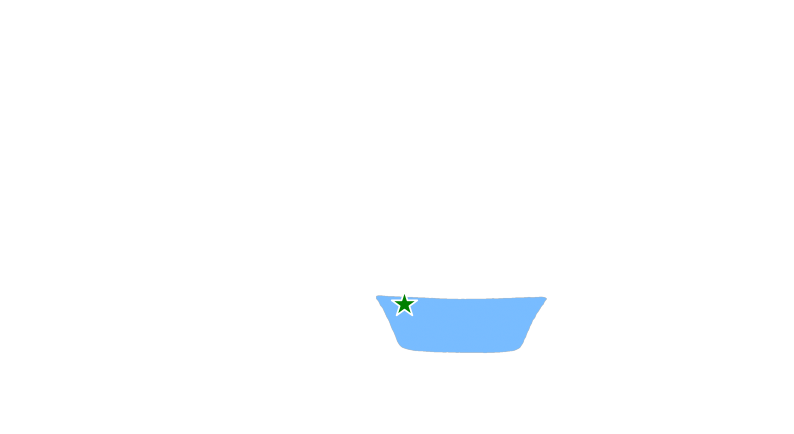

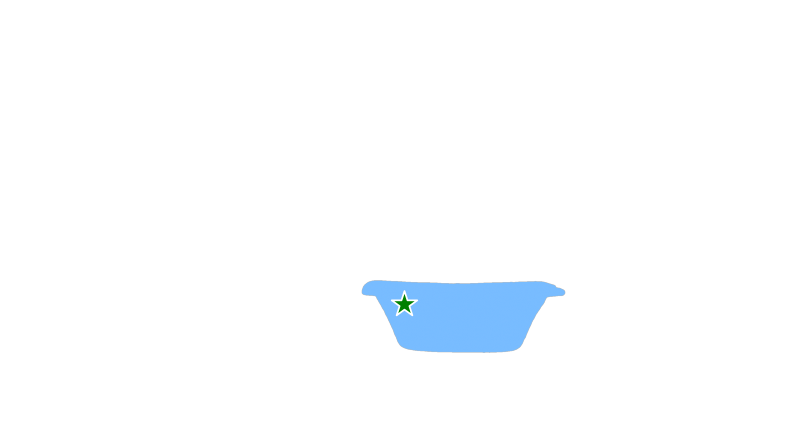

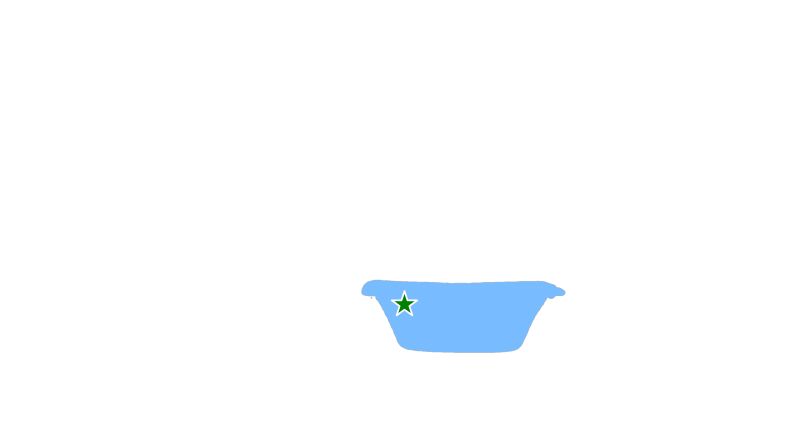

In [16]:
#|export

# Segment from arbitrary pixel coordinates
input_point = np.array([[1536.109375, 1149.078125]])
input_label = np.array([1])
masks, scores, logits = sam_predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

# Visualize the results
for i, (mask) in enumerate(masks):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    show_mask(mask, ax)
    show_points(input_point, input_label, ax)
    ax.axis('off')
    plt.show()

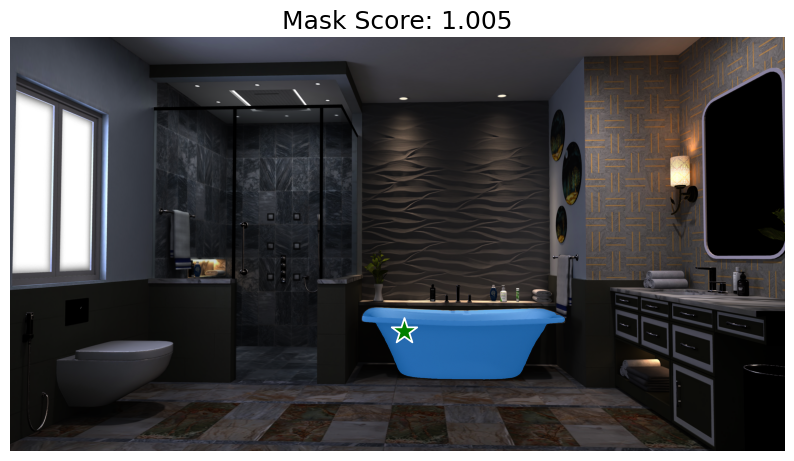

In [9]:
#|export
# Select highest scoring mask
highest_score_mask = max(zip(masks, scores), key = lambda x: x[1])
mask = highest_score_mask[0]
score = highest_score_mask[1]

# DEBUG - Display mask
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(mask, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.title(f"Mask Score: {score:.3f}", fontsize=18)
plt.axis('off')
plt.show()
